In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import numpy as np

df = pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\(GOV BONDS) Yield Curve Arbitrage\Data\Expected values of predictor variables (6 mo horizon - 31-12-2024)\Work\7-Year Breakeven Inflation Rate (%)\Data.csv")
name = "T7YIEM"
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.asfreq(pd.infer_freq(df.index))
last_value = df[name].iloc[-1]
df[name] = df[name].diff()
df=df.dropna()

result = adfuller(df[name])
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.00


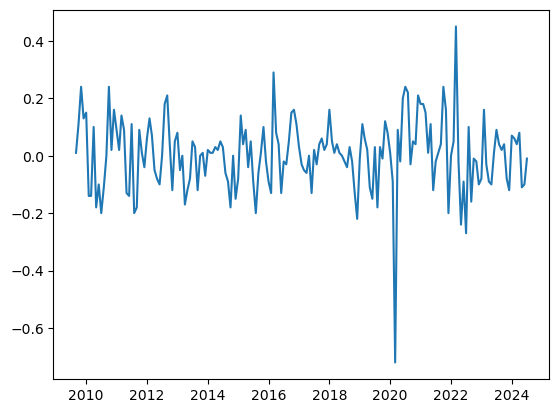

In [19]:
plt.plot(df)

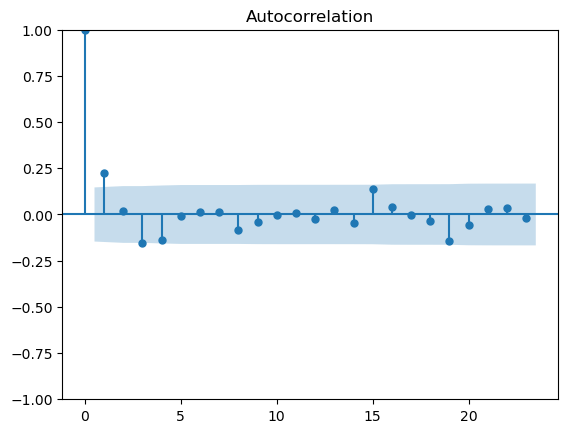

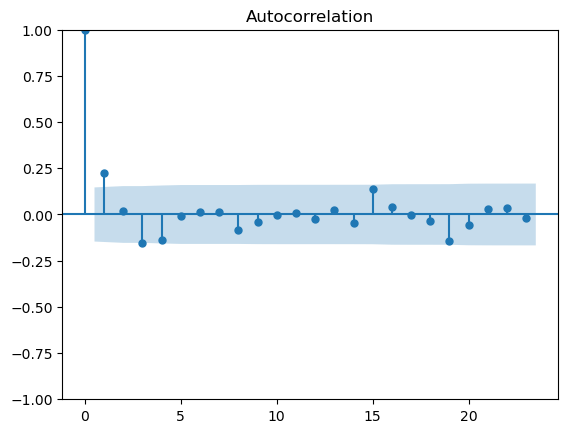

In [20]:
plot_acf(df[name])

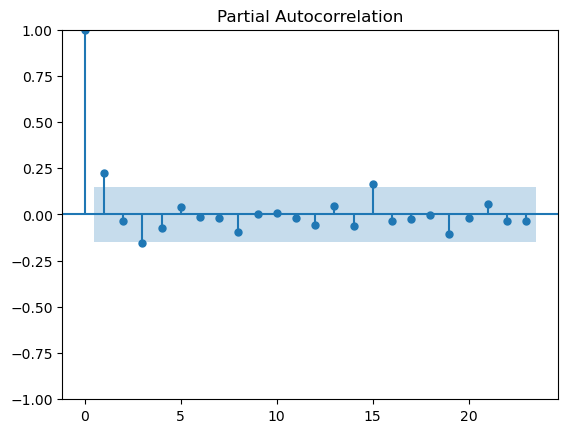

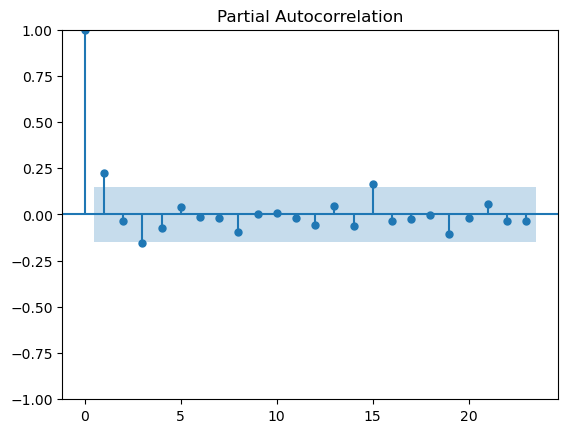

In [21]:
plot_pacf(df[name])

In [22]:
train_end = df.index[-6]

train_data = df[:train_end]
test_data = df[train_end:]

In [23]:
model = ARIMA(train_data, order=(3,1,1))
model_fit = model.fit()

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 T7YIEM   No. Observations:                  174
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 115.826
Date:                Sun, 01 Sep 2024   AIC                           -221.652
Time:                        18:49:11   BIC                           -205.886
Sample:                    09-01-2009   HQIC                          -215.256
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2282      0.064      3.565      0.000       0.103       0.354
ar.L2          0.0065      0.078      0.083      0.934      -0.147       0.160
ar.L3         -0.1530      0.091     -1.686      0.0

In [25]:
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

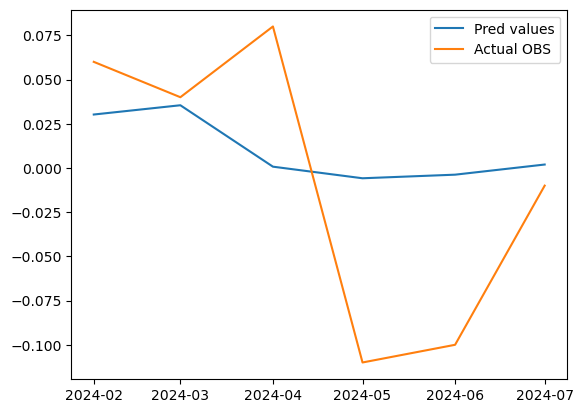

In [26]:
plt.plot(predictions, label = "Pred values")
plt.plot(test_data, label="Actual OBS")
plt.legend()

c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


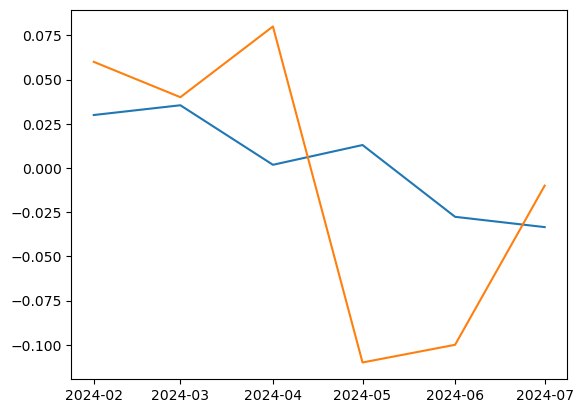

In [27]:
rolling_predictions = pd.Series(index=test_data.index) #initialise a series

for i in test_data.index:#give me the next week + timedelta(days=7)
    train_data = df[:i - DateOffset(months=1)]
    model = ARIMA(train_data, order=(3,1,1))
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions.loc[i] = pred

plt.plot(rolling_predictions, label='Pred values')
plt.plot(test_data, label='Actual OBS')

In [28]:
rolling_predictions = pd.DataFrame(rolling_predictions)
rolling_predictions.rename(columns={0: 'Predictions'}, inplace=True)
rolling_predictions

,Predictions
DATE,
2024-02-01,0.029930
2024-03-01,0.035453
2024-04-01,0.001788
2024-05-01,0.012966
2024-06-01,-0.027634
2024-07-01,-0.033453


In [29]:
test_data

,T7YIEM
DATE,
2024-02-01,0.06
2024-03-01,0.04
2024-04-01,0.08
2024-05-01,-0.11
2024-06-01,-0.10
2024-07-01,-0.01


In [30]:
residuals = test_data[name] - rolling_predictions['Predictions']
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.06825129157111591


c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

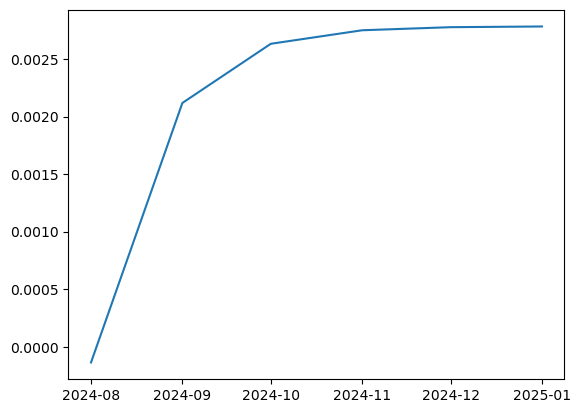

In [31]:
future_periods = 6  # e.g., predicting the next 6 months
future_dates = pd.date_range(start=df.index[-1] + DateOffset(months=1), periods=future_periods, freq='MS')
rolling_predictions = pd.Series(index=future_dates)

# Initialize the training data with the full df
train_data = df.copy()

# Iterate over each future period to make predictions
for i in range(future_periods):
    # Train the model on the current train_data
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Make the prediction for the next point
    pred = model_fit.forecast()
    
    # Determine the index of the new prediction
    next_index = train_data.index[-1] + DateOffset(months=1)
    
    # Append the prediction to the rolling_predictions and train_data
    rolling_predictions.loc[next_index] = pred
    train_data.loc[next_index] = pred  # this is adding the pred observation to the train data so as to consider it for the next prediction

plt.plot(rolling_predictions)


In [32]:
rolling_predictions

2024-08-01   -0.000137
2024-09-01    0.002118
2024-10-01    0.002632
2024-11-01    0.002749
2024-12-01    0.002776
2025-01-01    0.002782
Freq: MS, dtype: float64

In [33]:
df[name]

DATE
2009-09-01    0.01
2009-10-01    0.11
2009-11-01    0.24
2009-12-01    0.13
2010-01-01    0.15
              ... 
2024-03-01    0.04
2024-04-01    0.08
2024-05-01   -0.11
2024-06-01   -0.10
2024-07-01   -0.01
Freq: MS, Name: T7YIEM, Length: 179, dtype: float64

In [34]:
predictions = np.array(rolling_predictions)
original_values = [last_value]    
for i in predictions:
    new_value = original_values[-1] + i
    original_values.append(new_value)
    
the_actual_predictions_I_need = np.array(original_values[1:])
the_actual_predictions_I_need[-1]

2.232921031348465